# Моделирование лесных пожаров

В данной программе мы моделируем лес, деревья в кото-
ром непрерывно растут, а затем сгорают. На каждом этапе

моделирования существует равная 1 % вероятность того,

что на пустом месте вырастет дерево, а также 1 % вероятно-
сти того, что в дерево попадет молния и оно сгорит. Пожары

распространяются на непосредственно прилегающие к нему
деревья, поэтому более густой лес скорее пострадает от сильного
пожара, чем разреженный.

**Описание работы**


Эта программа — пример эмерджентного поведения, при котором взаимодействие
между простыми составляющими системы приводит к сложным закономерностям.

На пустых местах вырастают деревья, молнии их поджигают, а огонь превращает
деревья обратно в пустое пространство, распространяясь при этом на соседние
деревья. Подбирая различную скорость роста деревьев и частоту ударов молний,
вы можете добиться различных явлений.

Например, низкая вероятность удара молнии и высокая скорость роста приводят к обширным постоянным лесным по-
жарам, поскольку деревья располагаются кучно и быстро вырастают снова. Низкая же скорость роста деревьев при высокой вероятности ударов молний приводит
к возникновению нескольких маленьких пожаров, быстро потухающих из-за
отсутствия деревьев поблизости.

In [143]:
class ForestiInFire():
    import random
    import numpy as np
    import matplotlib.axes
    import matplotlib.pyplot as plt
    from typing import List, Dict, Tuple
    from shapely.geometry import Polygon, Point
    from matplotlib.patches import Circle, Rectangle 
    
    def __init__(self,
             count_lakes: int = 4,
             color_lakes: str = 'blue',
             city_square: int = 50,
             city_color: str = 'black',
             TREE: str = '/\\',
             FIRE: str = 'W',
             EMPTY: str = ' ',
             INITIAL_TREE_DENSITY: float = 0.5,
             GROW_CHANCE: float = 0.05,
             another_simulations: int = 3,
             FIRE_CHANCE: float = 0.05) -> None:
        """
        Инициализирует новый экземпляр класса ForestiInFire.

        Параметры:
        count_lakes (int): Количество озер в окружении.
        color_lakes (str): Цвет озер.
        city_square (int): Размер города (квадрата).
        city_color (str): Цвет города.
        TREE (str): Символ, представляющий дерево.
        FIRE (str): Символ, представляющий огонь.
        EMPTY (str): Символ, представляющий пустое место.
        INITIAL_TREE_DENSITY (float): Начальная плотность деревьев в лесу.
        GROW_CHANCE (float): Вероятность роста деревьев.
        another_simulations (int): Количество дополнительных симуляций.
        FIRE_CHANCE (float): Вероятность возникновения пожара.
        """
        self.count_lakes = count_lakes
        self.color_lakes = color_lakes
        self.city_square = city_square
        self.city_color = city_color
        self.WIDTH = 150
        self.HEIGHT = 150
        self.TREE = TREE
        self.FIRE = FIRE
        self.EMPTY = EMPTY
        self.INITIAL_TREE_DENSITY = INITIAL_TREE_DENSITY
        self.GROW_CHANCE = GROW_CHANCE
        self.FIRE_CHANCE = FIRE_CHANCE
        self.PAUSE = 2
        self.another_simulations = another_simulations


    def main(self):
        """
        Главный метод, запускает основной процесс симуляции пожара в лесу.

        Создает новый графический объект для отображения симуляции,
        устанавливает границы осей, вызывает методы для создания окружения,
        леса и озер, отображает результаты симуляции и показывает рисунок.

        Параметры:
        self: экземпляр класса ForestInFire.

        Возвращает:
        None.
        """
        _, ax = self.plt.subplots()
        ax.set_xlim(-150, 150)
        ax.set_ylim(-150, 150)
        ax.axis(False)

        square_polygon = self.draw_city(ax)
        circle_rad_center = self.draw_lake(ax, square_polygon=square_polygon)
        forest = self.create_new_forest(circle_rad_center, square_polygon)
        self.draw_forest(ax, forest)
        ax.text(-90, 165, 'Симуляция 0', fontsize=10, color='black', ha='right', va='top')
        self.plt.show()
        self.plt.pause(2)
        self.simulation(ax, square_polygon, circle_rad_center, forest)


    def draw_environment(self,
                     ax: matplotlib.axes.Axes,
                     square_polygon: Polygon,
                     circle_rad_center: List[Tuple[float, Tuple[float, float]]]) -> None:
        """
        Рисует окружение на графике.

        Параметры:
        self: экземпляр класса ForestInFire.
        ax: объект графика, на который будут нарисованы элементы окружения.
        square_polygon (Polygon): многоугольник, представляющий город.
        circle_rad_center (list(tuple)): список кортежей, каждый содержит радиус и центр озера.

        Возвращает:
        None.
        """
        # Рисуем окружности
        for rad, center in circle_rad_center:
            circle = self.plt.Circle(center, rad, color=self.color_lakes)
            ax.add_artist(circle)

        # Рисуем квадрат
        x, y = square_polygon.exterior.xy
        S_ = x[2] - x[0]
        C_ = S_//3
        square = self.plt.Rectangle((x[0], y[0]), S_, S_, color=self.city_color, alpha=0.8)
        ax.add_patch(square)

        # Рисуем маленькие квадраты
        for i in range(2):
            for j in range(2):
                subquare_x = x[0] + i * (S_ - C_)
                subquare_y = y[0] + j * (S_ - C_)
                subquare = self.plt.Rectangle((subquare_x, subquare_y), C_, C_,
                                        color=self.city_color, alpha=0.5)
                ax.add_patch(subquare)


    def simulation(self,
               ax: matplotlib.axes.Axes,
               square_polygon: Polygon,
               circle_rad_center: List[Tuple[float, Tuple[float, float]]],
               forest: Dict[Tuple[int, int], str],
               s: int = 0) -> None:
        """
        Проводит симуляцию распространения пожара в лесу.

        Параметры:
        self: экземпляр класса ForestInFire.
        ax: объект графика, на котором отображается симуляция.
        square_polygon (Polygon): многоугольник, представляющий город.
        circle_rad_center (list(tuple)): список кортежей, каждый содержит радиус и центр озера.
        forest (dict): словарь, представляющий текущее состояние леса.
        s (int): номер текущей симуляции (по умолчанию 0).

        Возвращает:
        None.
        """
        for _ in range(self.another_simulations):
            next_forest = forest.copy()
            for (x, y), value in forest.items():
                if value == self.EMPTY and self.random.random()*10 <= self.GROW_CHANCE:
                    next_forest[(x, y)] = self.TREE
                elif value == self.TREE and self.random.random()*10 <= self.FIRE_CHANCE:
                    next_forest[(x, y)] = self.FIRE
                elif value == self.FIRE:
                    for ix in range(-3, 4):
                        for iy in range(-3, 4):
                            if forest.get((x + ix, y + iy)) == self.TREE:
                                next_forest[(x + ix, y + iy)] = self.FIRE
                    next_forest[(x, y)] =self.EMPTY
            forest = next_forest

            # Отрисовка состояния леса на каждой итерации
            fig, ax = self.plt.subplots()
            ax.set_xlim(-150, 150)
            ax.set_ylim(-150, 150)
            ax.axis(False)
            self.draw_environment(ax, square_polygon, circle_rad_center)
            self.draw_forest(ax, forest)
            s+=1
            ax.text(-90, 165, f'Симуляция {s}', fontsize=10, color='black', ha='right', va='top')
            self.plt.pause(0.5)  # Пауза для отображения состояния перед следующей итерацией
        inp = input('Хотите симулировать еще раз?\n> ')
        if inp.isdigit():
            self.another_simulations = int(inp)
            self.simulation(ax, square_polygon,
                                    circle_rad_center, forest, s=s)
        else: print('Спасибо, приходите к нам еще!')


    def draw_forest(self,
                ax: matplotlib.axes.Axes,
                forest: Dict[Tuple[int, int], str]) -> None:
        """
        Отображает лес на графике.

        Параметры:
        self: экземпляр класса ForestInFire.
        ax: объект графика, на котором будет отображен лес.
        forest (dict): словарь, представляющий текущее состояние леса.

        Возвращает:
        None.
        """
        for key_, val_ in forest.items():
            if val_ == '/\\':
                ax.plot(key_[0], key_[1], c="green", marker="^")  # Отрисовка деревьев
            elif val_ == 'W':
                ax.plot(key_[0], key_[1], c="red", marker="x")  # Отрисовка огня

    
    def create_new_forest(self,
                      circle_rad_center: List[Tuple[float, Tuple[float, float]]],
                      square_polygon: Polygon) -> Dict[Tuple[int, int], str]:
        """
        Создает новый первоначальный лес на основе заданных параметров окружения.

        Параметры:
        self: экземпляр класса ForestInFire.
        circle_rad_center (list(tuple)): список кортежей, каждый содержит радиус и центр озера.
        square_polygon (Polygon): список кортежей, представляющий вершины многоугольника, описывающего город.

        Возвращает:
        forest (dict): словарь, представляющий новый лес с деревьями.
        """
        # Извлекаем радиусы и центры кругов
        rads = [rad for rad, _ in circle_rad_center]
        centers = [center for _, center in circle_rad_center]
        # Создаем множество координат всех точек
        all_points = {(x, y) for x in range(-self.WIDTH, self.WIDTH) for y in range(-self.HEIGHT, self.HEIGHT)
        if  not square_polygon.contains(self.Point(x,y))}
        # Удаляем точки, находящиеся внутри каждого круга
        for center, rad in zip(centers, rads):
            all_points -= {(x, y) for x, y in all_points if (x - center[0])**2 + (y - center[1])**2 <= rad**2}
        # Создаем лес, изначально все точки пустые
        forest = {point: self.EMPTY for point in all_points}
        # Добавляем деревья согласно начальной плотности
        for point in forest:
            if self.random.random()*10 <= self.INITIAL_TREE_DENSITY:
                forest[point] = self.TREE
        return forest
    

    def draw_city(self,
                  ax: matplotlib.axes.Axes) -> Polygon:
        """
        Рисует город на заданном графике.

        Параметры:
        self: экземпляр класса ForestInFire.
        ax: объект графика, на котором будет отображен город.

        Возвращает:
        square_polygon (Polygon): объект Polygon, представляющий границы города.
        """
        # Размер маленьких квадратов
        color = self.city_color
        S_ = self.city_square
        C_ = S_ // 3
        # Генерация случайной координаты для большого квадрата
        x = self.random.randint(-150, 150 - S_)
        y = self.random.randint(-150, 150 - S_)

        # Нарисовать большой квадрат
        square = self.plt.Rectangle((x, y), S_, S_, color=color, alpha=0.8)
        ax.add_patch(square)

        for i in range(2):
            for j in range(2):
                subquare_x = x + i * (S_ - C_)
                subquare_y = y + j * (S_ - C_)
                subquare = self.plt.Rectangle((subquare_x, subquare_y), C_, C_,
                                        color=color, alpha=0.5)
                ax.add_patch(subquare)

        # Создаем объект Polygon для представления квадрата
        square_polygon = self.Polygon([(x, y),
                                    (x + S_, y),
                                    (x + S_, y + S_),
                                    (x, y + S_)])

        # Список для хранения точек внутри квадрата
        points_inside_square = []

        # Перебираем все точки в предполагаемой области, где может находиться вторая фигура
        for x_ in range(x, x + S_):
            for y_ in range(y, y + S_):
                point = self.Point(x_, y_)
                # Проверяем, находится ли точка внутри квадрата
                if square_polygon.contains(point):
                    points_inside_square.append((x_, y_))
        return square_polygon


    def draw_lake(self,
                  ax: matplotlib.axes.Axes,
                  square_polygon: Polygon) -> List[Tuple[float, Tuple[float, float]]]:
        """
        Рисует озеро(а) на заданном графике в колличестве self.count_lakes.

        Параметры:
        self: экземпляр класса ForestInFire.
        ax: объект графика, на котором будет отображено озеро.
        square_polygon (Polygon): список кортежей, представляющий вершины многоугольника, описывающего город (по умолчанию [(1,1)]).

        Возвращает:
        circle_rad_center (list(tuple)): список кортежей, каждый содержит радиус и центр озера.
        """
        import random
        from matplotlib.patches import Circle
        from shapely.geometry import Point
        color = self.color_lakes
        circle_rad_center = []

        # Извлекаем координаты вершин квадрата
        square_coords = self.np.array(square_polygon.exterior.coords)

        # Создаем список допустимых точек вне квадрата
        valid_points = []
        for x in range(-150, 150, 1):
            for y in range(-150, 150, 1):
                point = Point(x, y)
                if not square_polygon.contains(point):
                    valid_points.append((x, y))

        for _ in range(self.count_lakes):
            # Выбираем случайные координаты и радиус из списка допустимых точек
            while True:
                circle_center = random.choice(valid_points)
                random_lake_radius = random.choice(range(10, 50, 5))

                min_distance_from_edges = min([abs(circle_center[0] - edge[0]) for edge in square_coords] +
                [abs(circle_center[1] - edge[1]) for edge in square_coords])
                if min_distance_from_edges >= random_lake_radius:
                    # Рисуем круг в заданном месте
                    circle = Circle(circle_center, random_lake_radius, color=color)
                    circle_rad_center.append((random_lake_radius, circle_center))
                    ax.add_patch(circle)
                    break
        return circle_rad_center

In [ ]:
# Для запуска скрипта
# if __name__ == "__main__":
#     forest = ForestInFire(FIRE_CHANCE=0.9,
#                           INITIAL_TREE_DENSITY=0.5,
#                           GROW_CHANCE=0.001,
#                           another_simulations=1)
#     forest.main()

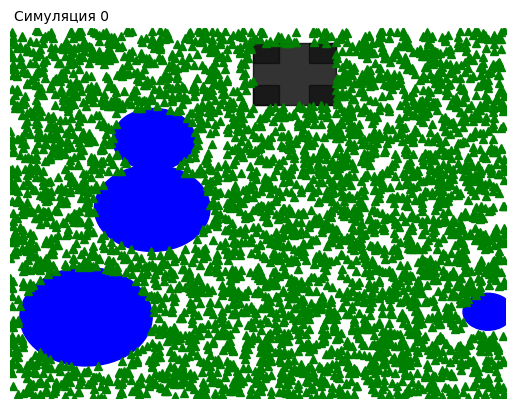

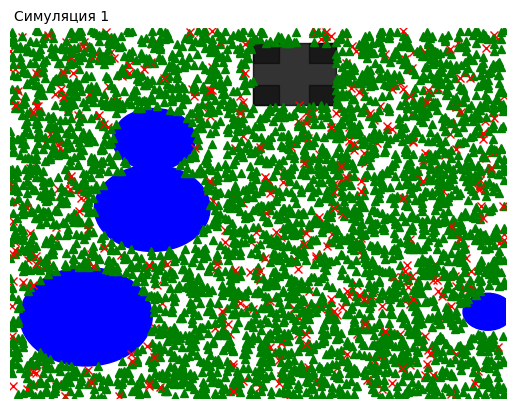

Спасибо, приходите к нам еще!


In [147]:
forest = ForestiInFire(FIRE_CHANCE=.9,
                       INITIAL_TREE_DENSITY = .5,
                       GROW_CHANCE = .001,
                       another_simulations=1)

forest.main()

wind

road

trees

fire

population

grafics